**Importing necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

**Loading and visualizing data**

In [2]:
df = pd.read_csv('/content/AirPassengers.csv')
print(df.head())
print(df.describe())

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121
       #Passengers
count   144.000000
mean    280.298611
std     119.966317
min     104.000000
25%     180.000000
50%     265.500000
75%     360.500000
max     622.000000


In [3]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

In [4]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    for i in range(1, n_steps+1):
        df[f'passengers(t-{i})'] = df['#Passengers'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 5
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df

,#Passengers,passengers(t-1),passengers(t-2),passengers(t-3),passengers(t-4),passengers(t-5)
Month,,,,,,
1949-06-01,135,121.0,129.0,132.0,118.0,112.0
1949-07-01,148,135.0,121.0,129.0,132.0,118.0
1949-08-01,148,148.0,135.0,121.0,129.0,132.0
1949-09-01,136,148.0,148.0,135.0,121.0,129.0
1949-10-01,119,136.0,148.0,148.0,135.0,121.0
...,...,...,...,...,...,...
1960-08-01,606,622.0,535.0,472.0,461.0,419.0
1960-09-01,508,606.0,622.0,535.0,472.0,461.0
1960-10-01,461,508.0,606.0,622.0,535.0,472.0


In [5]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np.shape

(139, 6)

In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

In [7]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((139, 5), (139,))

In [8]:
X = dc(np.flip(X, axis=1))
X.shape

(139, 5)

In [9]:
split_index = int(len(X) * 0.80)

split_index

111

In [10]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((111, 5), (28, 5), (111,), (28,))

In [11]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((111, 5, 1), (28, 5, 1), (111, 1), (28, 1))

In [12]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([111, 5, 1]),
 torch.Size([28, 5, 1]),
 torch.Size([111, 1]),
 torch.Size([28, 1]))

In [13]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [14]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to('cpu'), batch[1].to('cpu')
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 5, 1]) torch.Size([16, 1])


In [16]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to('cpu')
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to('cpu')

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to('cpu')
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [17]:
def calculate_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

In [18]:
def calculate_metrics_on_original_scale(y_true, y_pred, scaler):
    #dummy arrays for inverse transformation
    dummy_true = np.zeros((y_true.shape[0], lookback + 1))
    dummy_pred = np.zeros((y_pred.shape[0], lookback + 1))
    dummy_true[:, 0] = y_true.flatten()
    dummy_pred[:, 0] = y_pred.flatten()

    #inverse scaling
    original_true = scaler.inverse_transform(dummy_true)[:, 0]
    original_pred = scaler.inverse_transform(dummy_pred)[:, 0]

    # Calculating metrics
    rmse = np.sqrt(mean_squared_error(original_true, original_pred))
    mae = mean_absolute_error(original_true, original_pred)
    return rmse, mae

In [19]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to('cpu'), batch[1].to('cpu')

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [20]:
def validate_one_epoch():
    model.eval()
    running_loss = 0.0
    all_y_true = []
    all_y_pred = []

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to('cpu'), batch[1].to('cpu')

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

            all_y_true.append(y_batch.numpy())
            all_y_pred.append(output.numpy())

    avg_loss_across_batches = running_loss / len(test_loader)

    all_y_true = np.concatenate(all_y_true, axis=0)
    all_y_pred = np.concatenate(all_y_pred, axis=0)

    rmse, mae = calculate_metrics_on_original_scale(all_y_true, all_y_pred, scaler)

    print('Validation Loss: {0:.3f}, RMSE (Original Scale): {1:.3f}, MAE (Original Scale): {2:.3f}'.format(
        avg_loss_across_batches, rmse, mae))
    print('***************************************************')
    print()

In [23]:
learning_rate = 0.001
num_epochs = 200
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

# Evaluating final training metrics
with torch.no_grad():
    train_predictions = model(X_train.to('cpu')).to('cpu').numpy()
    train_rmse, train_mae = calculate_metrics_on_original_scale(
        y_train.numpy(), train_predictions, scaler)

    print('Final Training RMSE (Original Scale): {:.3f}, MAE (Original Scale): {:.3f}'.format(
        train_rmse, train_mae))

Epoch: 1

Validation Loss: 0.114, RMSE (Original Scale): 85.017, MAE (Original Scale): 62.634
***************************************************

Epoch: 2

Validation Loss: 0.116, RMSE (Original Scale): 85.570, MAE (Original Scale): 63.119
***************************************************

Epoch: 3

Validation Loss: 0.116, RMSE (Original Scale): 85.864, MAE (Original Scale): 63.402
***************************************************

Epoch: 4

Validation Loss: 0.115, RMSE (Original Scale): 85.341, MAE (Original Scale): 62.949
***************************************************

Epoch: 5

Validation Loss: 0.115, RMSE (Original Scale): 85.395, MAE (Original Scale): 63.079
***************************************************

Epoch: 6

Validation Loss: 0.114, RMSE (Original Scale): 84.883, MAE (Original Scale): 62.649
***************************************************

Epoch: 7

Validation Loss: 0.112, RMSE (Original Scale): 84.255, MAE (Original Scale): 62.089
************************

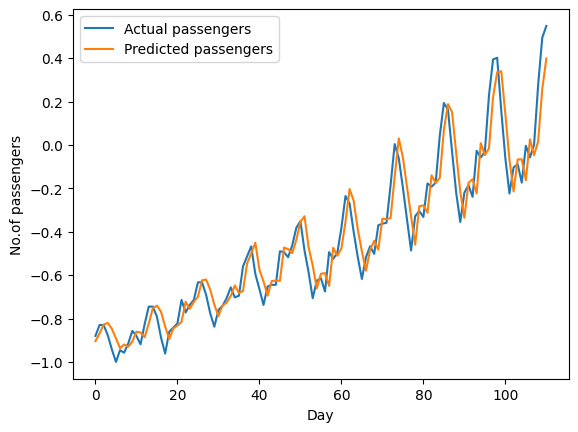

In [24]:
with torch.no_grad():
    predicted = model(X_train.to('cpu')).to('cpu').numpy()

plt.plot(y_train, label='Actual passengers')
plt.plot(predicted, label='Predicted passengers')
plt.xlabel('Day')
plt.ylabel('No.of passengers')
plt.legend()
plt.show()


In [25]:
test_predictions = model(X_test.to('cpu')).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([474.98140812, 400.35748637, 357.11056218, 311.57010032,
       346.0730639 , 366.36748925, 344.32391208, 407.55597889,
       395.06795765, 415.87278296, 454.04635119, 494.89511323,
       502.42656398, 451.7800802 , 401.68871719, 360.84464818,
       405.53592223, 414.33153899, 389.22459336, 415.31976557,
       447.06704175, 454.48306555, 488.74517357, 521.42106789,
       520.61346513, 482.72958738, 447.25928622, 386.43181519])

In [26]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([404.00000037, 359.00000008, 309.99999961, 337.00000061,
       360.        , 342.00000094, 405.99999973, 395.99999908,
       419.99999911, 471.99999788, 548.00000441, 559.00000668,
       462.99999884, 407.00000134, 362.00000002, 404.99999812,
       416.99999814, 391.00000068, 419.00000136, 461.00000334,
       471.99999788, 534.99999893, 622.        , 606.00000513,
       508.00000179, 461.00000334, 389.99999907, 432.00000298])

Test Data RMSE (Original Scale): 53.380, MAE (Original Scale): 45.510


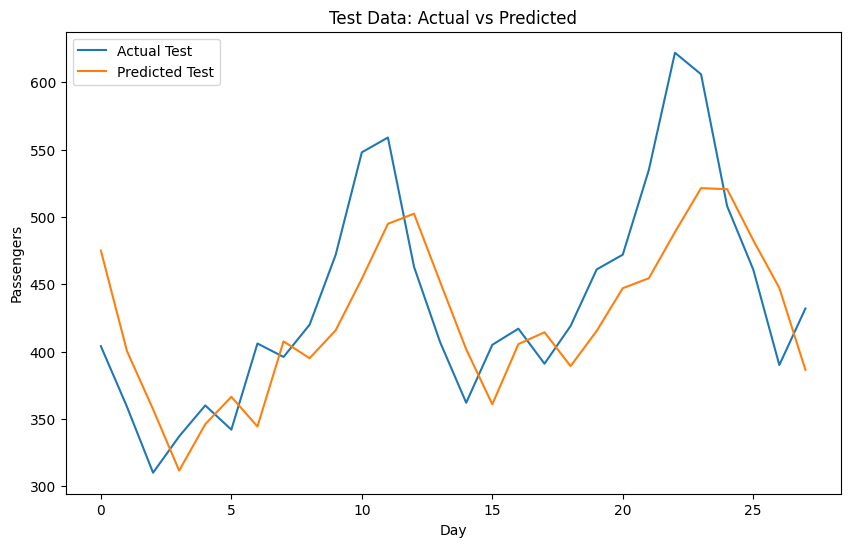

In [27]:
# Evaluating on test data
with torch.no_grad():
    test_predictions = model(X_test.to('cpu')).to('cpu').numpy()

    test_rmse, test_mae = calculate_metrics_on_original_scale(
        y_test.numpy(), test_predictions, scaler)

    print('Test Data RMSE (Original Scale): {:.3f}, MAE (Original Scale): {:.3f}'.format(
        test_rmse, test_mae))


dummy_test = np.zeros((X_test.shape[0], lookback + 1))
dummy_test[:, 0] = y_test.numpy().flatten()
actual_test_values = scaler.inverse_transform(dummy_test)[:, 0]

dummy_predictions = np.zeros((X_test.shape[0], lookback + 1))
dummy_predictions[:, 0] = test_predictions.flatten()
predicted_test_values = scaler.inverse_transform(dummy_predictions)[:, 0]


plt.figure(figsize=(10, 6))
plt.plot(actual_test_values, label='Actual Test')
plt.plot(predicted_test_values, label='Predicted Test')
plt.xlabel('Day')
plt.ylabel('Passengers')
plt.legend()
plt.title('Test Data: Actual vs Predicted')
plt.show()


**Estimating Hyperparameters using Approximate Bayesian Computation(ABC)**

In [30]:
# Define the prior distribution for the model parameters
def prior():
    hidden_size = np.random.randint(1, 10)
    learning_rate = np.random.uniform(0.0001, 0.01)
    return hidden_size, learning_rate

# Define the likelihood function
def likelihood(model, X, y, epsilon):
    model.eval()
    with torch.no_grad():
        predictions = model(X)
        error = torch.mean((predictions - y) ** 2).item()
    return error < epsilon

# Define the ABC rejection sampling method
def abc_rejection_sampling(num_samples, epsilon):
    accepted_samples = []
    while len(accepted_samples) < num_samples:
        hidden_size, learning_rate = prior()
        model = LSTM(1, hidden_size, 1).to('cpu')
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        loss_function = nn.MSELoss()

        # Train the model
        for epoch in range(50):
            model.train(True)
            for batch_index, batch in enumerate(train_loader):
                x_batch, y_batch = batch[0].to('cpu'), batch[1].to('cpu')
                optimizer.zero_grad()
                output = model(x_batch)
                loss = loss_function(output, y_batch)
                loss.backward()
                optimizer.step()

        # Evaluate the model
        if likelihood(model, X_test, y_test, epsilon):
            accepted_samples.append((hidden_size, learning_rate))

    return accepted_samples

In [31]:
# Perform ABC rejection sampling
num_samples = 10
epsilon = 0.1
accepted_samples = abc_rejection_sampling(num_samples, epsilon)

print("Accepted Samples:")
for sample in accepted_samples:
    print(f"Hidden Size: {sample[0]}, Learning Rate: {sample[1]}")

Accepted Samples:
Hidden Size: 9, Learning Rate: 0.004671098191357795
Hidden Size: 3, Learning Rate: 0.00860418145532802
Hidden Size: 6, Learning Rate: 0.0072017394032402385
Hidden Size: 5, Learning Rate: 0.009254278047358715
Hidden Size: 2, Learning Rate: 0.009767537245418345
Hidden Size: 4, Learning Rate: 0.0022477335216283213
Hidden Size: 2, Learning Rate: 0.00589507701956205
Hidden Size: 6, Learning Rate: 0.005628364105867918
Hidden Size: 1, Learning Rate: 0.008368962990829527
Hidden Size: 5, Learning Rate: 0.0046448367253188105


In [32]:
# Train the final model with the best parameters
best_hidden_size, best_learning_rate = accepted_samples[0]
model = LSTM(1, best_hidden_size, 1).to('cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=best_learning_rate)
loss_function = nn.MSELoss()

for epoch in range(300):
    model.train(True)
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to('cpu'), batch[1].to('cpu')
        optimizer.zero_grad()
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        loss.backward()
        optimizer.step()

In [33]:
# Evaluate the final model
model.eval()
with torch.no_grad():
    train_predictions = model(X_train.to('cpu')).numpy()
    test_predictions = model(X_test.to('cpu')).numpy()

rmse_train, mae_train = calculate_metrics_on_original_scale(y_train.numpy(), train_predictions, scaler)

print(f"Training Data RMSE (Original Scale): {rmse_train:.3f}")
print(f"Training Data MAE (Original Scale): {mae_train:.3f}")

rmse_test, mae_test = calculate_metrics_on_original_scale(y_test.numpy(), test_predictions, scaler)

print(f"Test Data RMSE (Original Scale): {rmse_test:.3f}")
print(f"Test Data MAE (Original Scale): {mae_test:.3f}")

Training Data RMSE (Original Scale): 22.164
Training Data MAE (Original Scale): 19.134
Test Data RMSE (Original Scale): 58.091
Test Data MAE (Original Scale): 48.010


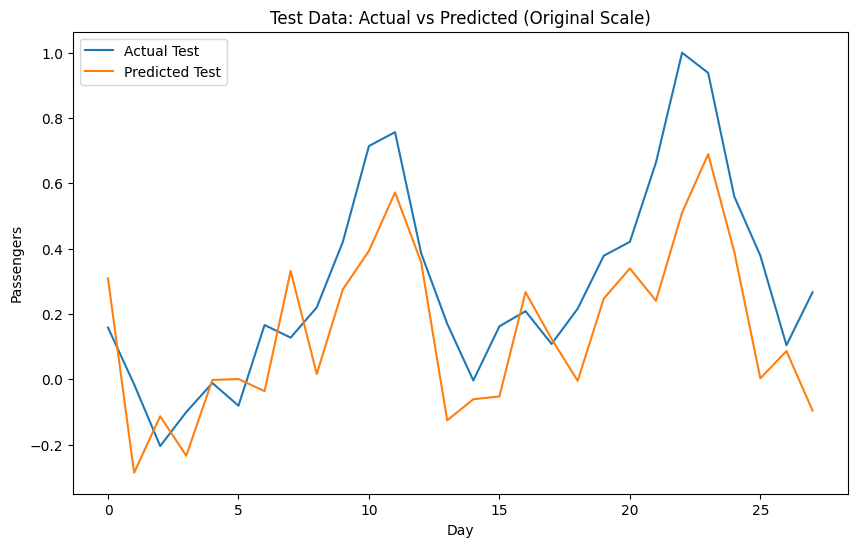

In [34]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Test')
plt.plot(test_predictions, label='Predicted Test')
plt.xlabel('Day')
plt.ylabel('Passengers')
plt.legend()
plt.title('Test Data: Actual vs Predicted (Original Scale)')
plt.show()